# Modeling CB1 ligands

In [344]:
#Load libraries
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from matplotlib import pyplot
import seaborn
import pandas as pd
import numpy as np
import csv
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm
from catboost import CatBoostRegressor


## Cleaning data

In [345]:
#Standardization of our compounds to get rid off salts and inorganics etc.
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [346]:
#Standadization of our compounds to remove salts and inorganics etc.
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
_carbonPatt = Chem.MolFromSmarts("[#6]")
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                Chem.SanitizeMol(mol)
                return mol
    else:
        return None

# Load data

In [347]:
#Load cannabinoid dataset
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]
with open("cannabinoid.csv") as inp:
    can = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in can:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "can"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [348]:
%%capture
#Load drugbank data
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })

In [349]:
# Create dataframe
df = pd.DataFrame((*drugbank, *[m for m in can if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )


In [350]:
df.head(5)

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,pChEMBL Value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x000002C0CC0...,<rdkit.Chem.rdchem.Mol object at 0x000002C0CA6...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.0,29,...,0,0,3,3,0,0,0,0,0,0
1,1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x000002C0844...,<rdkit.Chem.rdchem.Mol object at 0x000002C0848...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.0,16,...,0,0,4,2,0,0,0,0,2,1
2,2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x000002C0848...,<rdkit.Chem.rdchem.Mol object at 0x000002C0D31...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.0,15,...,0,0,1,2,0,0,0,1,0,0
3,3,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x000002C0DD1...,<rdkit.Chem.rdchem.Mol object at 0x000002C0CBF...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.0,16,...,0,0,1,5,0,0,0,0,2,1
4,4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x000002C0CBB...,<rdkit.Chem.rdchem.Mol object at 0x000002C0CC0...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.0,12,...,0,0,0,0,0,0,0,1,0,0


In [351]:
mx = df["Standard Value"].max()+1
df["Standard Value"] = df["Standard Value"].fillna(mx+1)

In [352]:
#SVR
svr = svm.SVR()
svr.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

SVR()

In [353]:
res = pd.DataFrame(svr.predict(df[(f"MQN_{x}" for x in range(1, 43))])).join(df[["Standard Value", "source"]])
res.columns = ["Prediction", "Standard Value", "Source"]
(res["Prediction"]-res["Standard Value"]).abs().mean()

7702921.360485191

In [354]:
(res[res["Source"]=="can"]["Prediction"]-res[res["Source"]=="can"]["Standard Value"]).abs().mean()

2965108.8692580583

In [355]:
#Functions to get results
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error cannabinoids: {(res[res["Source"]=="can"]["Prediction"]-res[res["Source"]=="can"][predicted_value]).abs().mean()}""")
    return res

In [356]:
res = get_results(svr, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 7702921.360485191
Average error cannabinoids: 2965108.8692580583


# Graphs

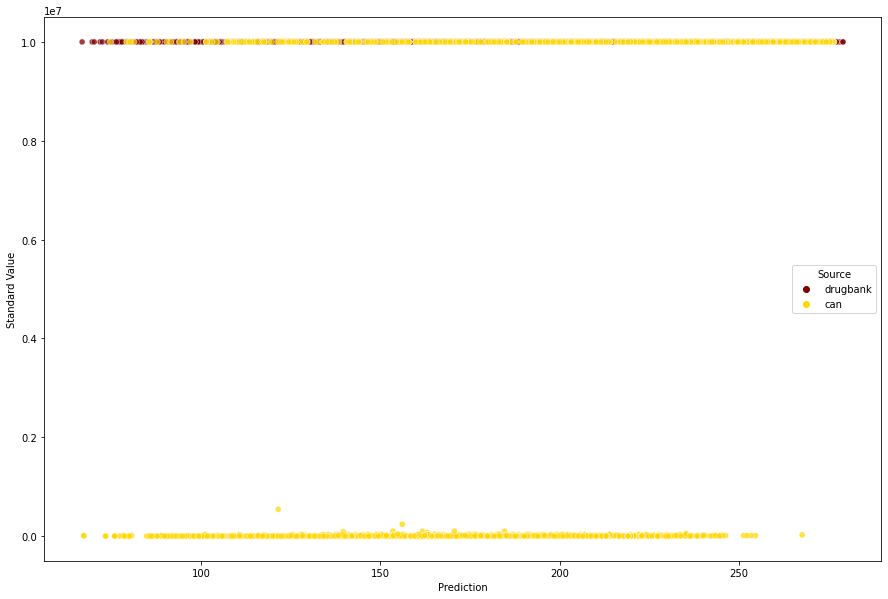

In [357]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res,
                      hue="Source",
                      legend="brief",
                      palette=['maroon','gold'],
                      ax=ax,
                      alpha=0.75
                     )


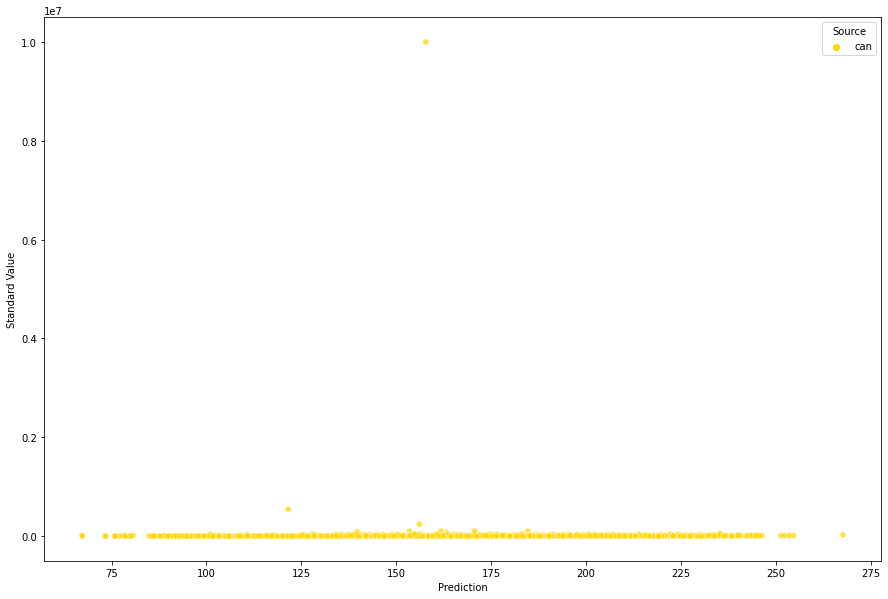

In [358]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx],
                      hue="Source",
                      legend="brief",
                      palette= ['gold'],
                      ax=ax,
                      alpha=0.75
                     )

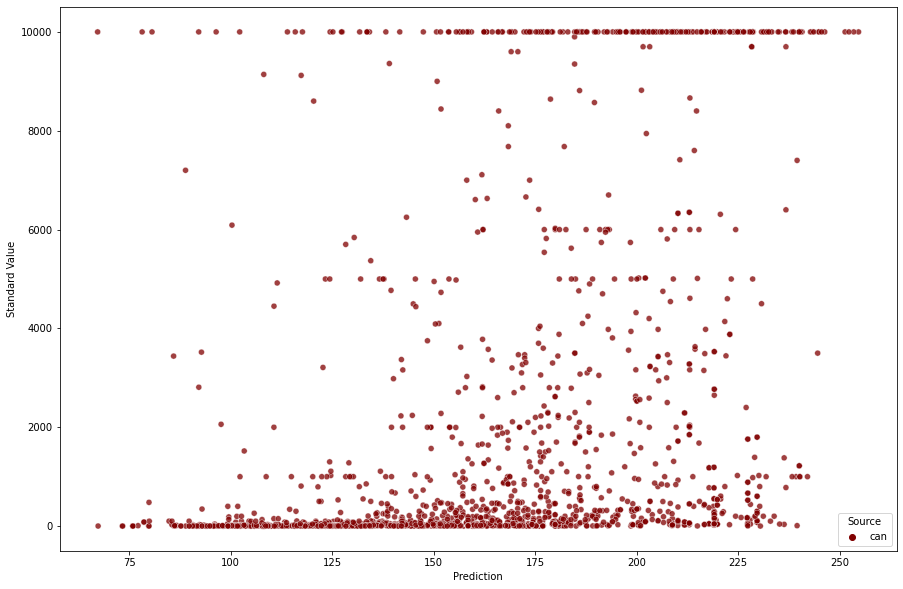

In [359]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx/1000],
                      hue="Source",
                      legend="brief",
                      palette= ['maroon'],
                      ax=ax,
                      alpha=0.75
                     )

# Random forest

In [360]:
#Use Random forest regression
rf = ensemble.RandomForestRegressor()
rf.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

RandomForestRegressor()

In [361]:
#Get result
res_rf = get_results(rf, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 7577461.583999644
Average error cannabinoids: 2923279.529387449


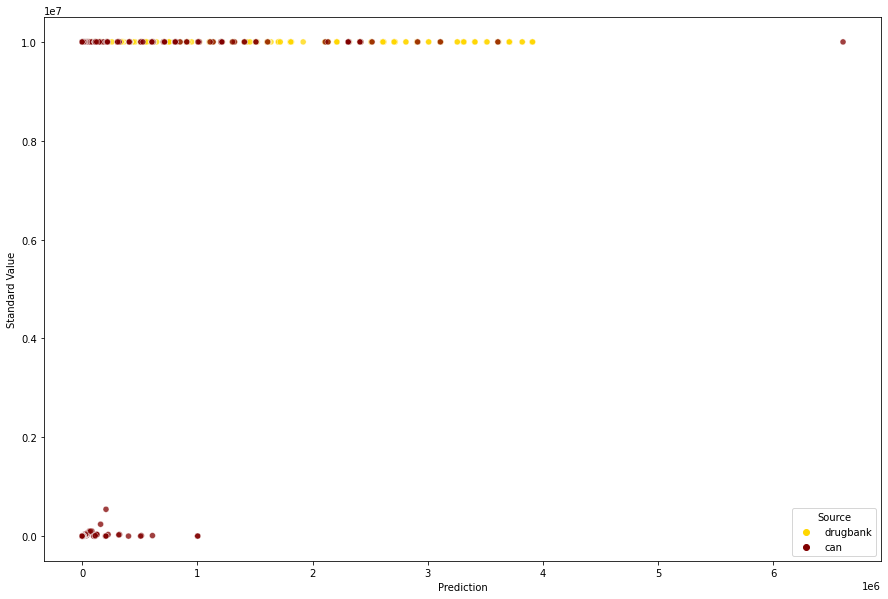

In [362]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                    palette= ['gold', 'maroon'],
                      alpha=0.75
                     )

C:\Users\katka\anaconda3\envs\cdd\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


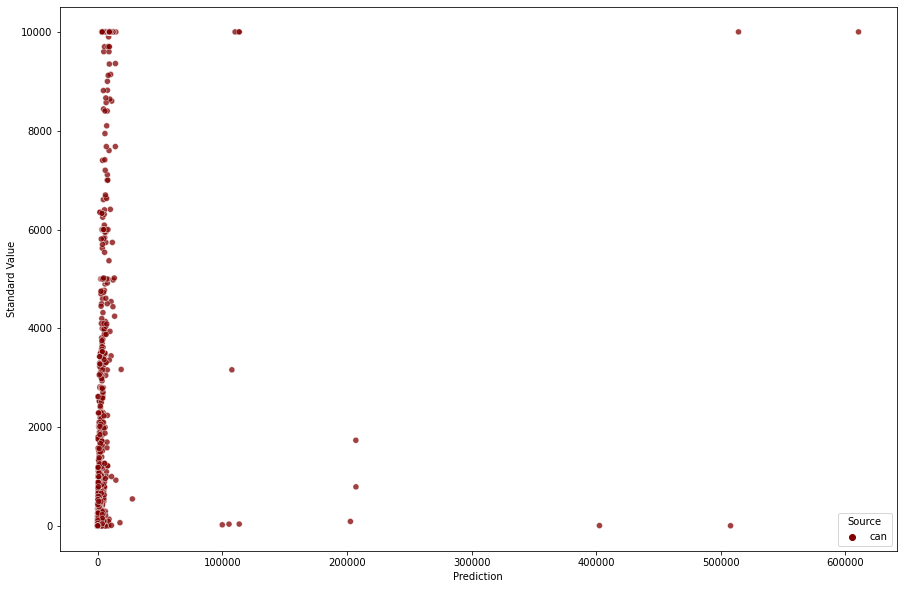

In [363]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf[res_rf["Standard Value"]<mx/1000][res_rf["Prediction"]<1e6],
                      hue="Source",
                      legend="brief",
                      palette= ['maroon'],
                      ax=ax,
                      alpha=0.75
                     )

#  SVR

In [364]:
#Use SVR
svr_p = svm.SVR()
svr_p.fit(df[df["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]>0]["pChEMBL Value"])

SVR()

In [365]:
res_svr_p = get_results(svr_p, df, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 4.883939613162507
Average error cannabinoids: 3.013213361147357


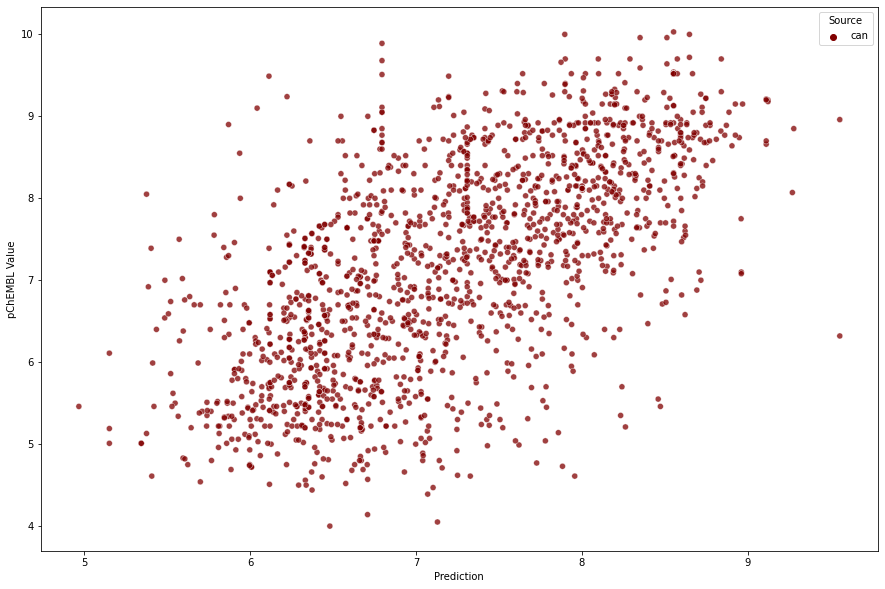

In [366]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_p[res_svr_p["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                    palette= ['maroon'],
                      ax=ax,
                      alpha=0.75
                     )

# SVR with PCA

In [367]:
#Normalize data and use principal component analysis
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

In [368]:
svr_np = svm.SVR()
svr_np.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR()

In [369]:
#Get results for svr
res_svr_np = res = get_results(svr_np, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 2.9457873797081637
Average error cannabinoids: 2.0386863689726242


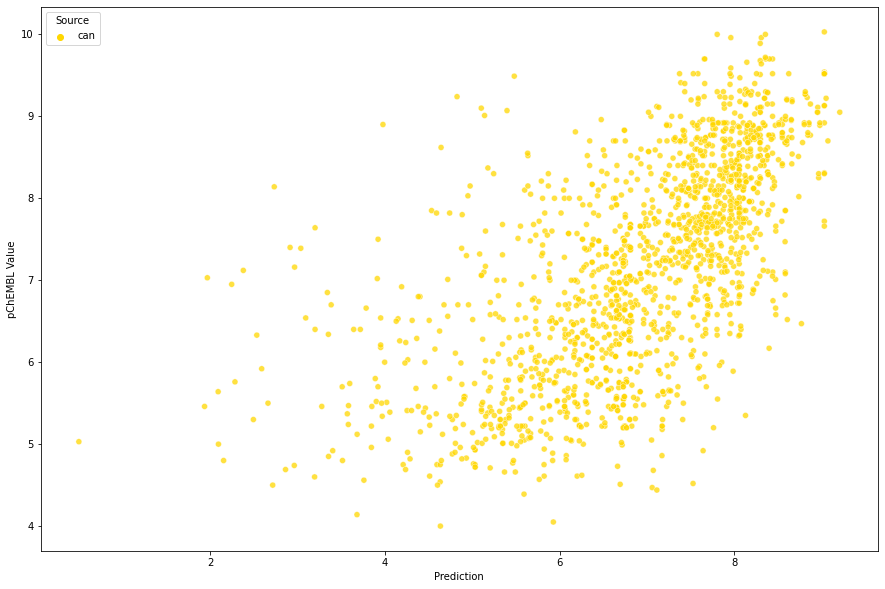

In [370]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_np[res_svr_np["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      palette= ['gold'],
                      ax=ax,
                      alpha=0.75
                     )

In [371]:
svr_poly = svm.SVR(kernel='poly')
svr_poly.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR(kernel='poly')

In [372]:
res_poly = get_results(svr_poly, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 5.522501430037836
Average error cannabinoids: 3.008494538946079


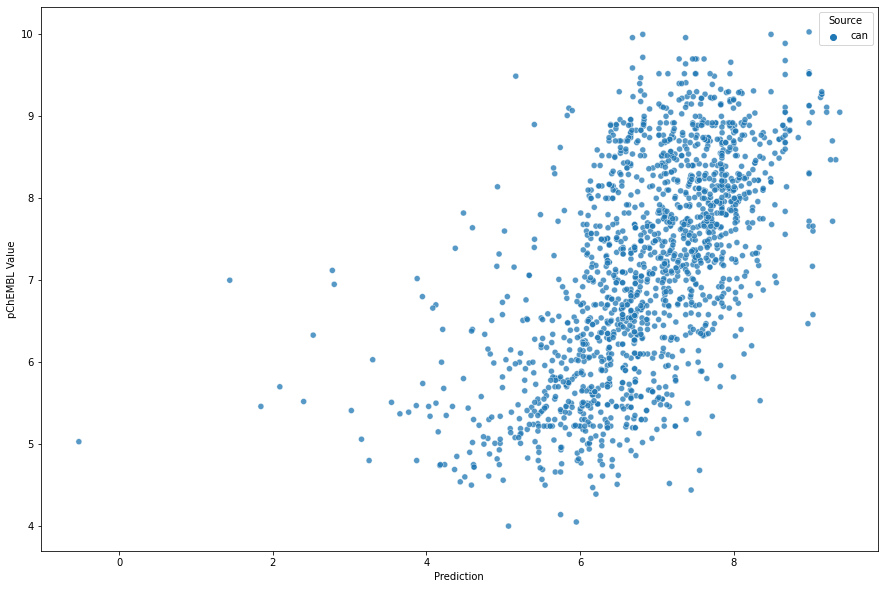

In [373]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_poly[res_poly["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# Split data

In [374]:
#Split data
trainset, testset = ms.train_test_split(df[df["pChEMBL Value"]>0])

In [375]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [376]:
#Check out lenght
len(trainset), len(testset)

(1273, 425)

In [377]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor()

In [378]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.3045809781063728
Average error cannabinoids: 0.3045809781063728


In [379]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.5609730550760261
Average error cannabinoids: 0.5609730550760261


In [380]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.68
R: 0.82
MSE: 0.51


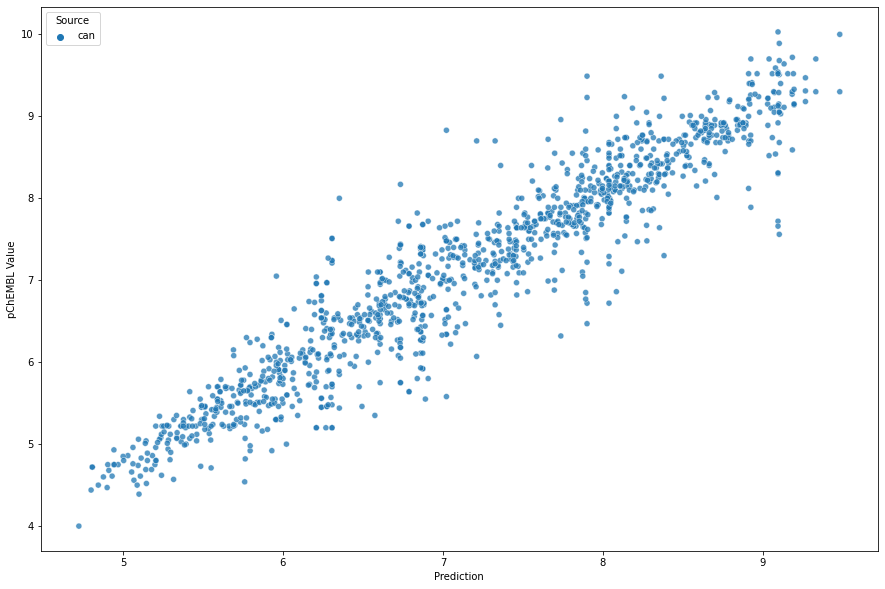

In [381]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

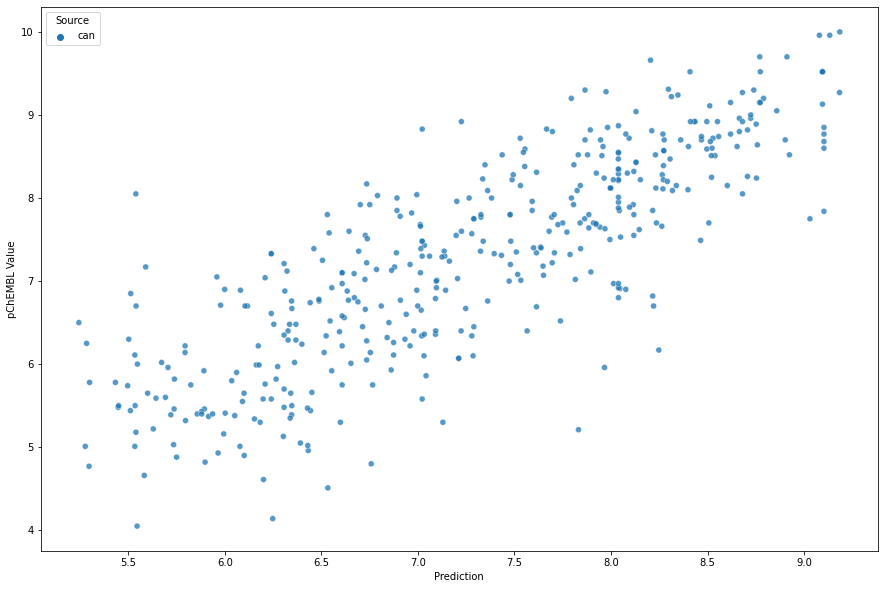

In [382]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# Using Morgan fingerprints


In [550]:
df = df[df["pChEMBL Value"]>0]

In [551]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(df['fps'].to_list(),
                                                    df['pChEMBL Value'].to_list(), 
                                                    test_size=0.3,random_state = 42)

### RandomForest

In [552]:
rf_clf = ensemble.RandomForestRegressor()

In [553]:
#train classifier
rf_clf.fit(X_train, y_train)

RandomForestRegressor()

In [554]:
#make predictions on train data
y_pred_train = rf_clf.predict(X_train)

In [555]:
#make predictions on test data
y_pred = rf_clf.predict(X_test)

In [556]:
print("R^2: %0.2f" % rf_model.score(X_test, y_test))
print("R: %0.2f" % np.sqrt(rf_model.score(X_test,  y_test)))
print("MSE: %0.2f" %  mean_squared_error(y_test, y_pred))

R^2: 0.69
R: 0.83
MSE: 0.56


In [557]:
d = {'Prediction': y_pred, 'pChEMBL': y_test}
df_pd = pd.DataFrame(data=d)

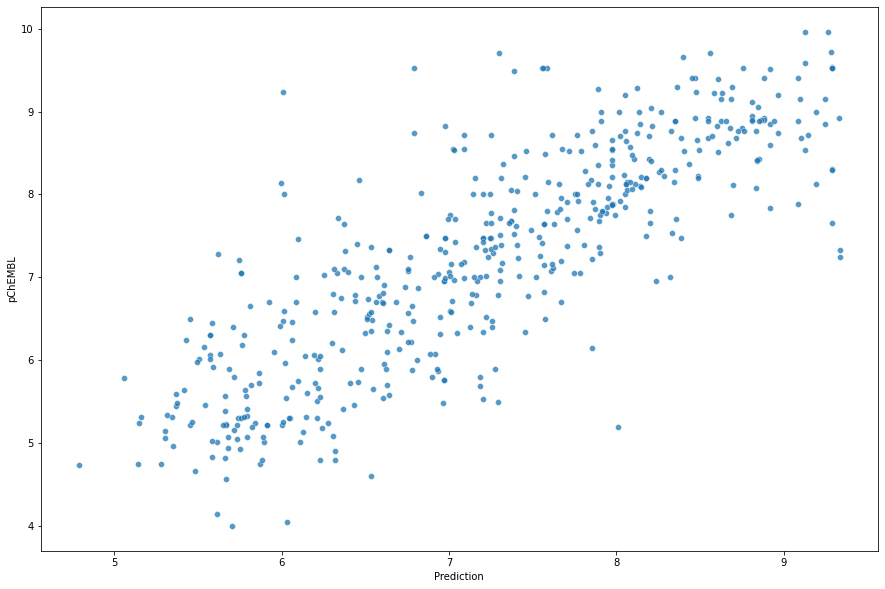

In [558]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x= 'Prediction',
                      y= 'pChEMBL',
                      data=df_pd,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### SVM

In [559]:
svr_p = svm.SVR()
svr_p.fit(X_train, y_train)

SVR()

In [560]:
#make predictions on train data
y_pred_train = svr_p.predict(X_train)

In [561]:
#make predictions on test data
y_pred = svr_p.predict(X_test)

In [562]:
print("R^2: %0.2f" % svr_p.score(X_test, y_test))
print("R: %0.2f" % np.sqrt(svr_p.score(X_test,  y_test)))
print("MSE: %0.2f" %  mean_squared_error(y_test, y_pred))

R^2: 0.69
R: 0.83
MSE: 0.55


In [563]:
d = {'Prediction': y_pred, 'pChEMBL': y_test}
df_pd = pd.DataFrame(data=d)

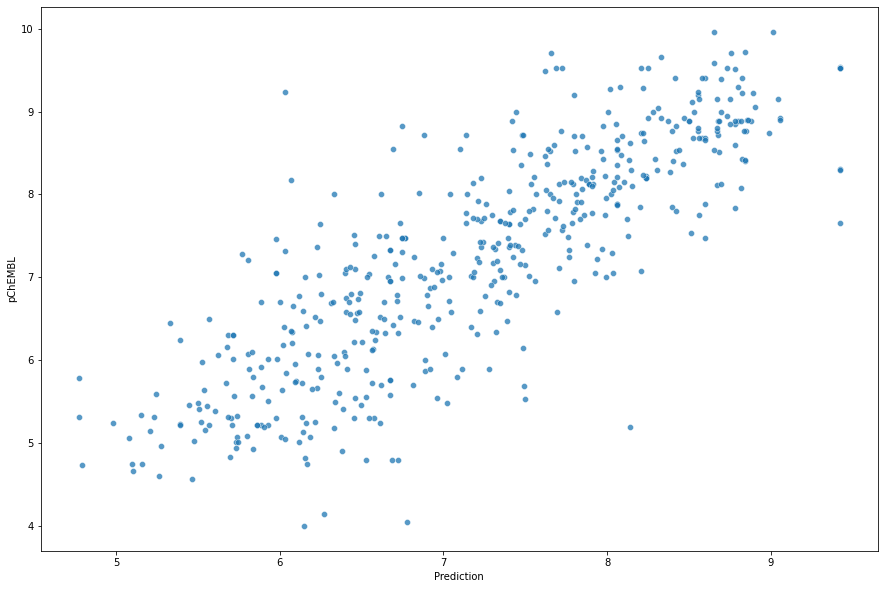

In [564]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x= 'Prediction',
                      y= 'pChEMBL',
                      data=df_pd,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### Lightgbm

In [565]:
lgbm = lightgbm.LGBMRegressor()

In [566]:
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [567]:
#make predictions on train data
y_pred_train = lgbm.predict(X_train)

In [568]:
#make predictions on test data
y_pred = lgbm.predict(X_test)

In [569]:
print("R^2: %0.2f" % lgbm.score(X_test, y_test))
print("R: %0.2f" % np.sqrt(lgbm.score(X_test,  y_test)))
print("MSE: %0.2f" %  mean_squared_error(y_test, y_pred))

R^2: 0.71
R: 0.84
MSE: 0.51


In [570]:
d = {'Prediction': y_pred, 'pChEMBL': y_test}
df_pd = pd.DataFrame(data=d)

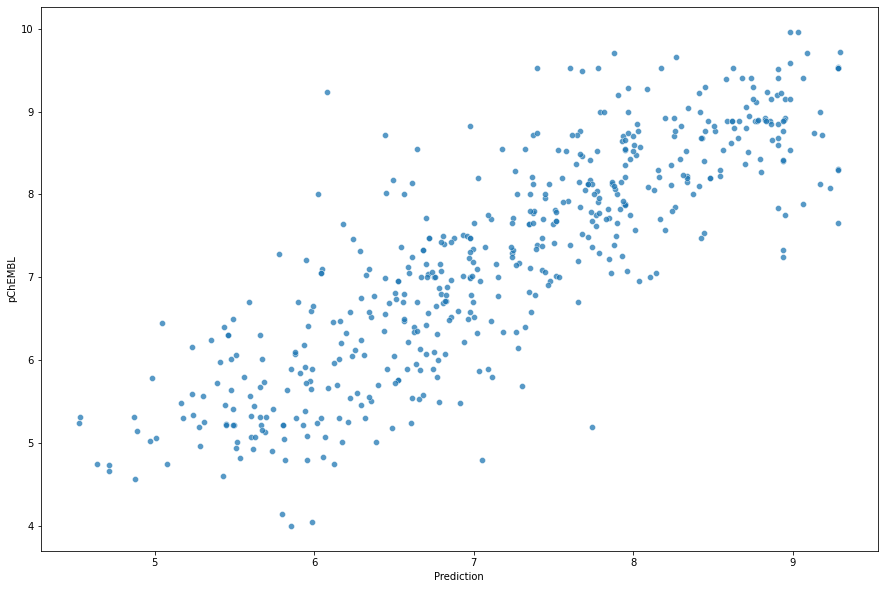

In [571]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x= 'Prediction',
                      y= 'pChEMBL',
                      data=df_pd,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### CatBoostRegressor

In [572]:
cat = CatBoostRegressor(silent = True)

In [573]:
cat.fit(X_train, y_train)
#make predictions on train data
y_pred_train = cat.predict(X_train)

In [574]:
#make predictions on test data
y_pred = cat.predict(X_test)

In [575]:
print("R^2: %0.2f" % cat.score(X_test, y_test))
print("R: %0.2f" % np.sqrt(cat.score(X_test,  y_test)))
print("MSE: %0.2f" %  mean_squared_error(y_test, y_pred))

R^2: 0.70
R: 0.83
MSE: 0.55


In [576]:
d = {'Prediction': y_pred, 'pChEMBL': y_test}
df_pd = pd.DataFrame(data=d)

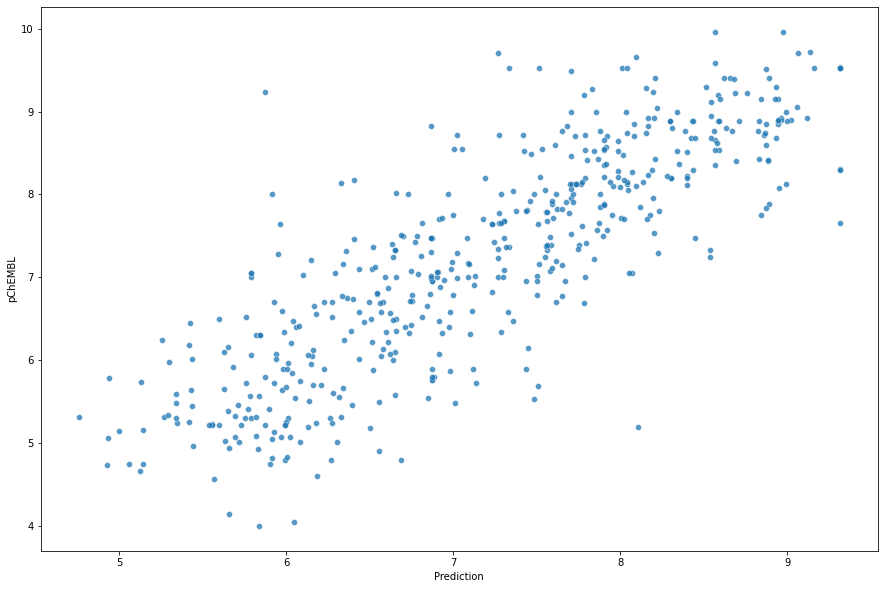

In [577]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x= 'Prediction',
                      y= 'pChEMBL',
                      data=df_pd,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### Results
So, I used RandomForestRegressor, CatBoostRegressor, SVM and LightgbmRegressor. All these models gave similiar results, however the best results were achieved using LightgbmRegressor, were the MSE was 0.51 and R^2 0.71. It seems that fingerprints as feature for prediction seem like one of the best options.